# Intraday RVOL: Time-of-Day Volume Analysis

**Problem**: Regular RVOL compares volume to recent average, but doesn't account for natural intraday patterns:
- Market open (9:30-10:00): Naturally high volume
- Lunch (12:00-13:00): Naturally low volume
- Market close (15:30-16:00): Naturally high volume

**Solution**: Intraday RVOL compares volume to **historical average for that specific time of day**.

**Use Cases:**
- Identify "unusual for this time" volume spikes
- Avoid false signals during predictable volume patterns
- Intraday trading strategies

In [1]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from indikator.rvol import rvol, rvol_intraday

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

2025-11-27 16:21:45.171 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'fill_value' has constraints: {'gt': 0.0}
2025-11-27 16:21:45.172 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'epsilon' has constraints: {'gt': 0.0}
2025-11-27 16:21:45.172 | DEBUG    | hipr.config:configurable:705 - Creating Config for 'churn_factor' with 2 hyperparameter(s): ['fill_value', 'epsilon']
2025-11-27 16:21:45.346 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'threshold' has constraints: {'ge': 0.0, 'le': 1.0}
2025-11-27 16:21:45.347 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'min_distance_pct' has constraints: {'ge': 0.0, 'le': 1.0}
2025-11-27 16:21:45.348 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'confirmation_bars' has constraints: {'ge': 0}
2025-11-27 16:21:45.353 | DEBUG    | hipr.config:_extract_hyper_field_info:620 - Parameter 'epsilon' has constraints: {'gt': 0.0}
2025-11-27 16:21:45.3

## Scenario 1: Normal Market Pattern (No Spike)
Shows how regular RVOL can give false signals during normal intraday patterns

/tmp/sselcuk/ipykernel_2578481/3589239026.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


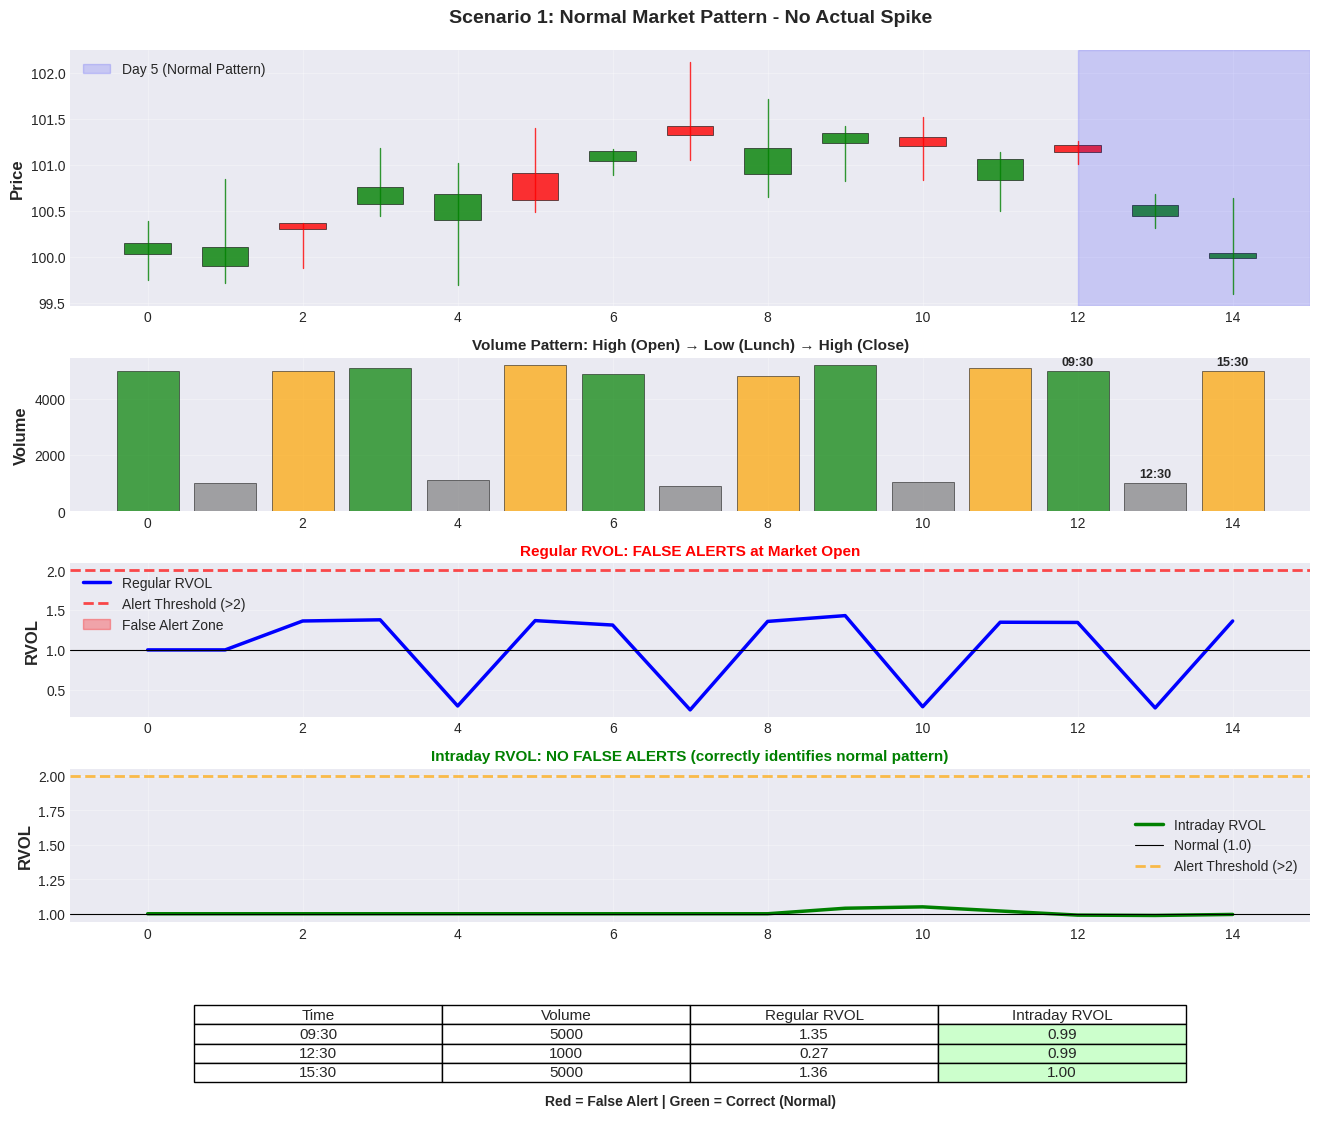

Day 5 Analysis:
  09:30 (Open): Volume is HIGH but NORMAL for market open
    Regular RVOL:  1.35 (compares to recent avg including lunch)
    Intraday RVOL: 0.99 (compares to historical 09:30)

  12:30 (Lunch): Volume is LOW but NORMAL for lunch
    Regular RVOL:  0.27
    Intraday RVOL: 0.99

Intraday RVOL correctly identifies this as a normal trading day!


In [2]:
# Create 5 days of normal market pattern: high volume at open/close, low at lunch
dates1 = pd.to_datetime([
    # Day 1
    "2024-01-01 09:30", "2024-01-01 12:30", "2024-01-01 15:30",
    # Day 2
    "2024-01-02 09:30", "2024-01-02 12:30", "2024-01-02 15:30",
    # Day 3
    "2024-01-03 09:30", "2024-01-03 12:30", "2024-01-03 15:30",
    # Day 4
    "2024-01-04 09:30", "2024-01-04 12:30", "2024-01-04 15:30",
    # Day 5 - focus day
    "2024-01-05 09:30", "2024-01-05 12:30", "2024-01-05 15:30",
])

# Realistic volume pattern: open=5000, lunch=1000, close=5000 (with small variations)
volumes1 = np.array([
    5000, 1000, 5000,  # Day 1
    5100, 1100, 5200,  # Day 2
    4900, 900, 4800,   # Day 3
    5200, 1050, 5100,  # Day 4
    5000, 1000, 5000,  # Day 5 - normal pattern
])

# Create realistic price data with candlesticks
base_price = 100
price_changes = np.cumsum(np.random.randn(15) * 0.3)
closes1 = base_price + price_changes
opens1 = closes1 + np.random.randn(15) * 0.2
highs1 = np.maximum(opens1, closes1) + np.abs(np.random.randn(15)) * 0.4
lows1 = np.minimum(opens1, closes1) - np.abs(np.random.randn(15)) * 0.4

df1 = pd.DataFrame({
    'open': opens1, 'high': highs1, 'low': lows1, 'close': closes1, 'volume': volumes1
}, index=dates1)

# Calculate both RVOL types
result_regular = rvol(df1, window=3)
result_intraday = rvol_intraday(df1, min_samples=3)

# Plot
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(5, 1, height_ratios=[2.5, 1.5, 1.5, 1.5, 1.5], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)
ax4 = fig.add_subplot(gs[3], sharex=ax1)
ax5 = fig.add_subplot(gs[4], sharex=ax1)

# Candlesticks
for i in range(len(df1)):
    color = 'green' if df1['close'].iloc[i] >= df1['open'].iloc[i] else 'red'
    ax1.plot([i, i], [df1['low'].iloc[i], df1['high'].iloc[i]], color=color, linewidth=1, alpha=0.8)
    height = abs(df1['close'].iloc[i] - df1['open'].iloc[i])
    if height < 0.05: height = 0.1
    bottom = min(df1['open'].iloc[i], df1['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8))

# Highlight Day 5
ax1.axvspan(12, 15, alpha=0.15, color='blue', label='Day 5 (Normal Pattern)')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Scenario 1: Normal Market Pattern - No Actual Spike', fontsize=14, fontweight='bold', pad=20)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, len(df1))

# Volume bars with time-of-day labels
colors_vol = ['green' if i % 3 == 0 else 'orange' if i % 3 == 2 else 'gray' for i in range(len(df1))]
ax2.bar(range(len(df1)), df1['volume'], color=colors_vol, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
ax2.set_title('Volume Pattern: High (Open) → Low (Lunch) → High (Close)', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(df1))

# Add time labels
for i in [12, 13, 14]:
    time = df1.index[i].strftime('%H:%M')
    ax2.text(i, df1['volume'].iloc[i] + 200, time, ha='center', fontsize=9, fontweight='bold')

# Regular RVOL
rvol_reg = result_regular['rvol'].values
ax3.plot(range(len(rvol_reg)), rvol_reg, 'blue', linewidth=2.5, label='Regular RVOL')
ax3.axhline(1, color='black', linestyle='-', linewidth=0.8)
ax3.axhline(2, color='red', linestyle='--', linewidth=2, label='Alert Threshold (>2)', alpha=0.7)
ax3.fill_between(range(len(df1)), 2, rvol_reg, where=(rvol_reg > 2), alpha=0.3, color='red', label='False Alert Zone')
ax3.set_ylabel('RVOL', fontsize=12, fontweight='bold')
ax3.set_title('Regular RVOL: FALSE ALERTS at Market Open', fontsize=11, fontweight='bold', color='red')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, len(df1))

# Intraday RVOL
rvol_intra = result_intraday['rvol_intraday'].values
ax4.plot(range(len(rvol_intra)), rvol_intra, 'green', linewidth=2.5, label='Intraday RVOL')
ax4.axhline(1, color='black', linestyle='-', linewidth=0.8, label='Normal (1.0)')
ax4.axhline(2, color='orange', linestyle='--', linewidth=2, label='Alert Threshold (>2)', alpha=0.7)
ax4.set_ylabel('RVOL', fontsize=12, fontweight='bold')
ax4.set_title('Intraday RVOL: NO FALSE ALERTS (correctly identifies normal pattern)', fontsize=11, fontweight='bold', color='green')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-1, len(df1))

# Comparison table
ax5.axis('off')
table_data = []
for i in [12, 13, 14]:  # Day 5
    time = df1.index[i].strftime('%H:%M')
    vol = df1['volume'].iloc[i]
    reg = result_regular['rvol'].iloc[i]
    intra = result_intraday['rvol_intraday'].iloc[i]
    table_data.append([time, f"{vol:.0f}", f"{reg:.2f}", f"{intra:.2f}"])

table = ax5.table(cellText=table_data,
                  colLabels=['Time', 'Volume', 'Regular RVOL', 'Intraday RVOL'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0.1, 0.3, 0.8, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Color code the problematic cells
for i in range(1, 4):
    if float(table_data[i-1][2]) > 2.0:  # Regular RVOL > 2
        table[(i, 2)].set_facecolor('#ffcccc')  # Light red
    if float(table_data[i-1][3]) > 2.0:  # Intraday RVOL > 2
        table[(i, 3)].set_facecolor('#ffcccc')
    else:
        table[(i, 3)].set_facecolor('#ccffcc')  # Light green

ax5.text(0.5, 0.15, 'Red = False Alert | Green = Correct (Normal)', 
         ha='center', fontsize=10, fontweight='bold', transform=ax5.transAxes)

plt.tight_layout()
plt.show()

print("Day 5 Analysis:")
print("  09:30 (Open): Volume is HIGH but NORMAL for market open")
print(f"    Regular RVOL:  {result_regular['rvol'].iloc[12]:.2f} (compares to recent avg including lunch)")
print(f"    Intraday RVOL: {result_intraday['rvol_intraday'].iloc[12]:.2f} (compares to historical 09:30)")
print("\n  12:30 (Lunch): Volume is LOW but NORMAL for lunch")
print(f"    Regular RVOL:  {result_regular['rvol'].iloc[13]:.2f}")
print(f"    Intraday RVOL: {result_intraday['rvol_intraday'].iloc[13]:.2f}")
print("\nIntraday RVOL correctly identifies this as a normal trading day!")

## Scenario 2: Actual Spike at Market Open
Shows how intraday RVOL detects TRUE anomalies even at naturally high-volume times

/tmp/sselcuk/ipykernel_2578481/624833739.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


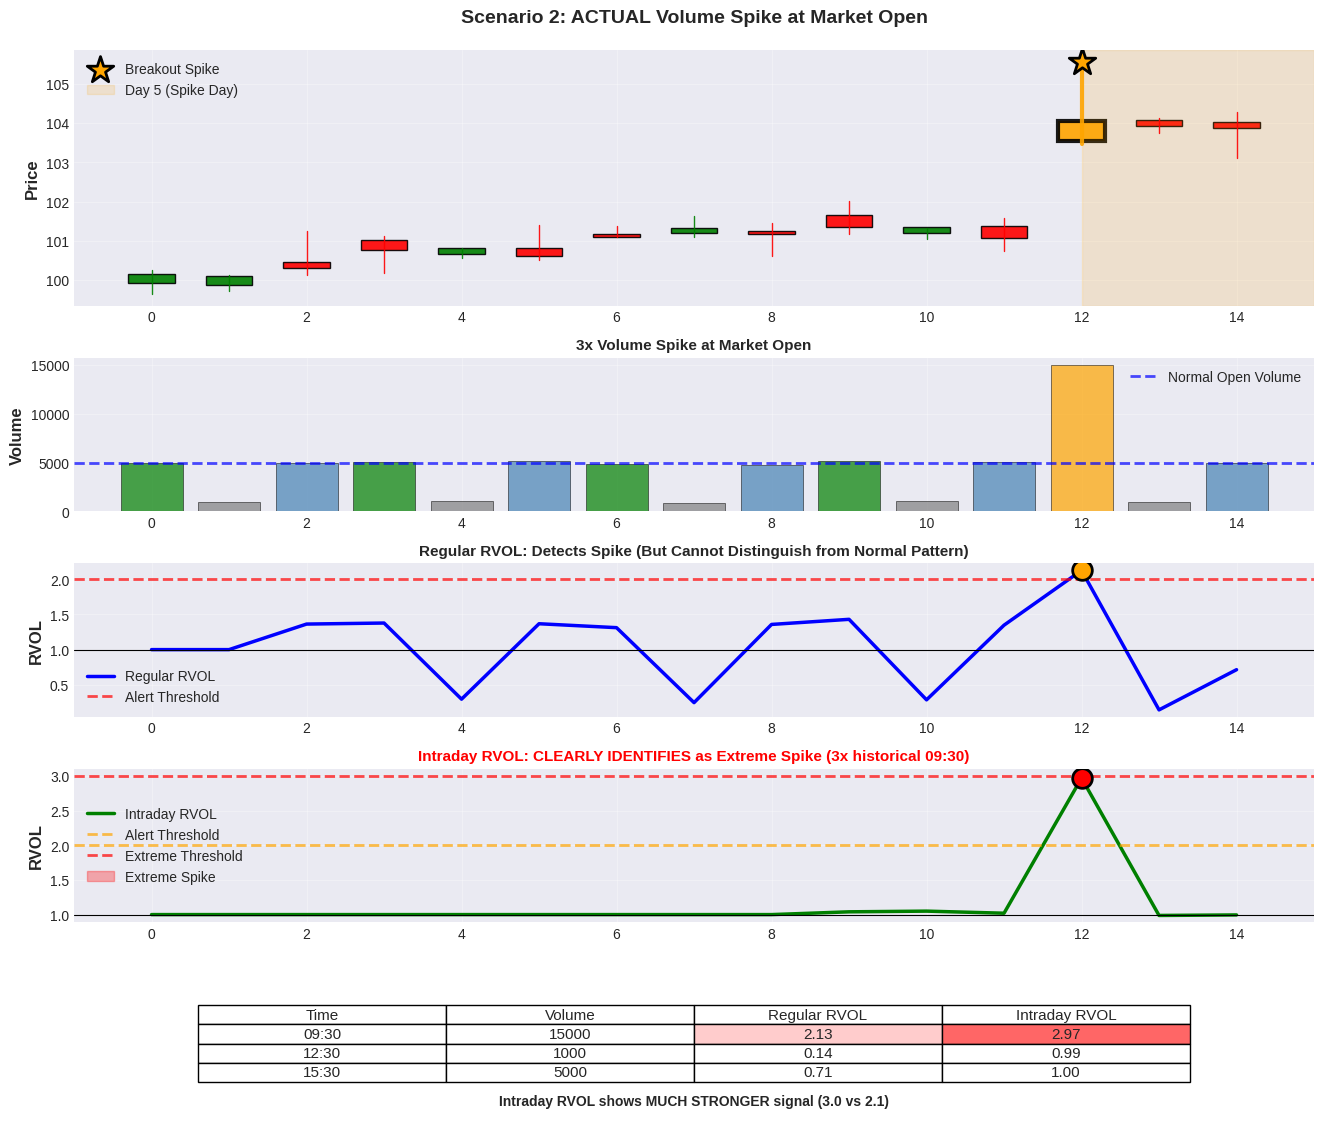

Spike Detection Comparison:
  Regular RVOL:  2.13
    → Compares 15000 to recent average (~3700 including lunch)
  Intraday RVOL: 2.97
    → Compares 15000 to historical 09:30 average (~5000)

Intraday RVOL provides MUCH CLEARER signal of genuine anomaly!


In [3]:
# Same setup but Day 5 has ACTUAL spike at open
dates2 = dates1.copy()

volumes2 = np.array([
    5000, 1000, 5000,  # Day 1
    5100, 1100, 5200,  # Day 2
    4900, 900, 4800,   # Day 3
    5200, 1050, 5100,  # Day 4
    15000, 1000, 5000,  # Day 5 - SPIKE at open (3x normal)
])

# Price action: gap up on the spike
closes2 = closes1.copy()
closes2[12] = closes2[11] + 3  # Gap up on spike
closes2[13:] = closes2[12] + np.cumsum(np.random.randn(2) * 0.3)

opens2 = closes2 + np.random.randn(15) * 0.2
highs2 = np.maximum(opens2, closes2) + np.abs(np.random.randn(15)) * 0.4
lows2 = np.minimum(opens2, closes2) - np.abs(np.random.randn(15)) * 0.4
highs2[12] = closes2[12] + 1.5  # Make spike bar dramatic

df2 = pd.DataFrame({
    'open': opens2, 'high': highs2, 'low': lows2, 'close': closes2, 'volume': volumes2
}, index=dates2)

result_regular2 = rvol(df2, window=3)
result_intraday2 = rvol_intraday(df2, min_samples=3)

# Plot
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(5, 1, height_ratios=[2.5, 1.5, 1.5, 1.5, 1.5], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)
ax4 = fig.add_subplot(gs[3], sharex=ax1)
ax5 = fig.add_subplot(gs[4], sharex=ax1)

# Candlesticks
for i in range(len(df2)):
    if i == 12:  # Spike bar
        color = 'orange'
        lw = 3
    else:
        color = 'green' if df2['close'].iloc[i] >= df2['open'].iloc[i] else 'red'
        lw = 1
    ax1.plot([i, i], [df2['low'].iloc[i], df2['high'].iloc[i]], color=color, linewidth=lw, alpha=0.9)
    height = abs(df2['close'].iloc[i] - df2['open'].iloc[i])
    if height < 0.05: height = 0.15
    bottom = min(df2['open'].iloc[i], df2['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=lw, alpha=0.9))

ax1.scatter([12], [df2['high'].iloc[12]], s=400, marker='*', color='orange', edgecolor='black', linewidth=2, zorder=5, label='Breakout Spike')
ax1.axvspan(12, 15, alpha=0.15, color='orange', label='Day 5 (Spike Day)')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Scenario 2: ACTUAL Volume Spike at Market Open', fontsize=14, fontweight='bold', pad=20)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, len(df2))

# Volume
colors_vol2 = ['orange' if i == 12 else 'green' if i % 3 == 0 else 'steelblue' if i % 3 == 2 else 'gray' for i in range(len(df2))]
ax2.bar(range(len(df2)), df2['volume'], color=colors_vol2, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.axhline(5000, color='blue', linestyle='--', label='Normal Open Volume', linewidth=2, alpha=0.7)
ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
ax2.set_title('3x Volume Spike at Market Open', fontsize=11, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(df2))

# Regular RVOL
rvol_reg2 = result_regular2['rvol'].values
ax3.plot(range(len(rvol_reg2)), rvol_reg2, 'blue', linewidth=2.5, label='Regular RVOL')
ax3.axhline(1, color='black', linestyle='-', linewidth=0.8)
ax3.axhline(2, color='red', linestyle='--', linewidth=2, label='Alert Threshold', alpha=0.7)
ax3.scatter([12], [rvol_reg2[12]], s=200, color='orange', edgecolor='black', linewidth=2, zorder=5)
ax3.set_ylabel('RVOL', fontsize=12, fontweight='bold')
ax3.set_title('Regular RVOL: Detects Spike (But Cannot Distinguish from Normal Pattern)', fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, len(df2))

# Intraday RVOL
rvol_intra2 = result_intraday2['rvol_intraday'].values
ax4.plot(range(len(rvol_intra2)), rvol_intra2, 'green', linewidth=2.5, label='Intraday RVOL')
ax4.axhline(1, color='black', linestyle='-', linewidth=0.8)
ax4.axhline(2, color='orange', linestyle='--', linewidth=2, label='Alert Threshold', alpha=0.7)
ax4.axhline(3, color='red', linestyle='--', linewidth=2, label='Extreme Threshold', alpha=0.7)
ax4.scatter([12], [rvol_intra2[12]], s=200, color='red', edgecolor='black', linewidth=2, zorder=5)
ax4.fill_between(range(len(df2)), 3, rvol_intra2, where=(rvol_intra2 > 3), alpha=0.3, color='red', label='Extreme Spike')
ax4.set_ylabel('RVOL', fontsize=12, fontweight='bold')
ax4.set_title('Intraday RVOL: CLEARLY IDENTIFIES as Extreme Spike (3x historical 09:30)', fontsize=11, fontweight='bold', color='red')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-1, len(df2))

# Comparison
ax5.axis('off')
table_data2 = []
for i in [12, 13, 14]:
    time = df2.index[i].strftime('%H:%M')
    vol = df2['volume'].iloc[i]
    reg = result_regular2['rvol'].iloc[i]
    intra = result_intraday2['rvol_intraday'].iloc[i]
    table_data2.append([time, f"{vol:.0f}", f"{reg:.2f}", f"{intra:.2f}"])

table2 = ax5.table(cellText=table_data2,
                   colLabels=['Time', 'Volume', 'Regular RVOL', 'Intraday RVOL'],
                   cellLoc='center',
                   loc='center',
                   bbox=[0.1, 0.3, 0.8, 0.5])
table2.auto_set_font_size(False)
table2.set_fontsize(11)
table2.scale(1, 2)

# Highlight the spike
table2[(1, 3)].set_facecolor('#ff6666')  # Bright red for extreme spike
table2[(1, 2)].set_facecolor('#ffcccc')  # Light red

ax5.text(0.5, 0.15, 'Intraday RVOL shows MUCH STRONGER signal (3.0 vs 2.1)', 
         ha='center', fontsize=10, fontweight='bold', transform=ax5.transAxes)

plt.tight_layout()
plt.show()

print("Spike Detection Comparison:")
print(f"  Regular RVOL:  {result_regular2['rvol'].iloc[12]:.2f}")
print(f"    → Compares 15000 to recent average (~3700 including lunch)")
print(f"  Intraday RVOL: {result_intraday2['rvol_intraday'].iloc[12]:.2f}")
print(f"    → Compares 15000 to historical 09:30 average (~5000)")
print("\nIntraday RVOL provides MUCH CLEARER signal of genuine anomaly!")

## Scenario 3: Lunch Hour Spike (Unusual)
Shows how intraday RVOL excels at detecting anomalies during typically quiet periods

/tmp/sselcuk/ipykernel_2578481/1996018403.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


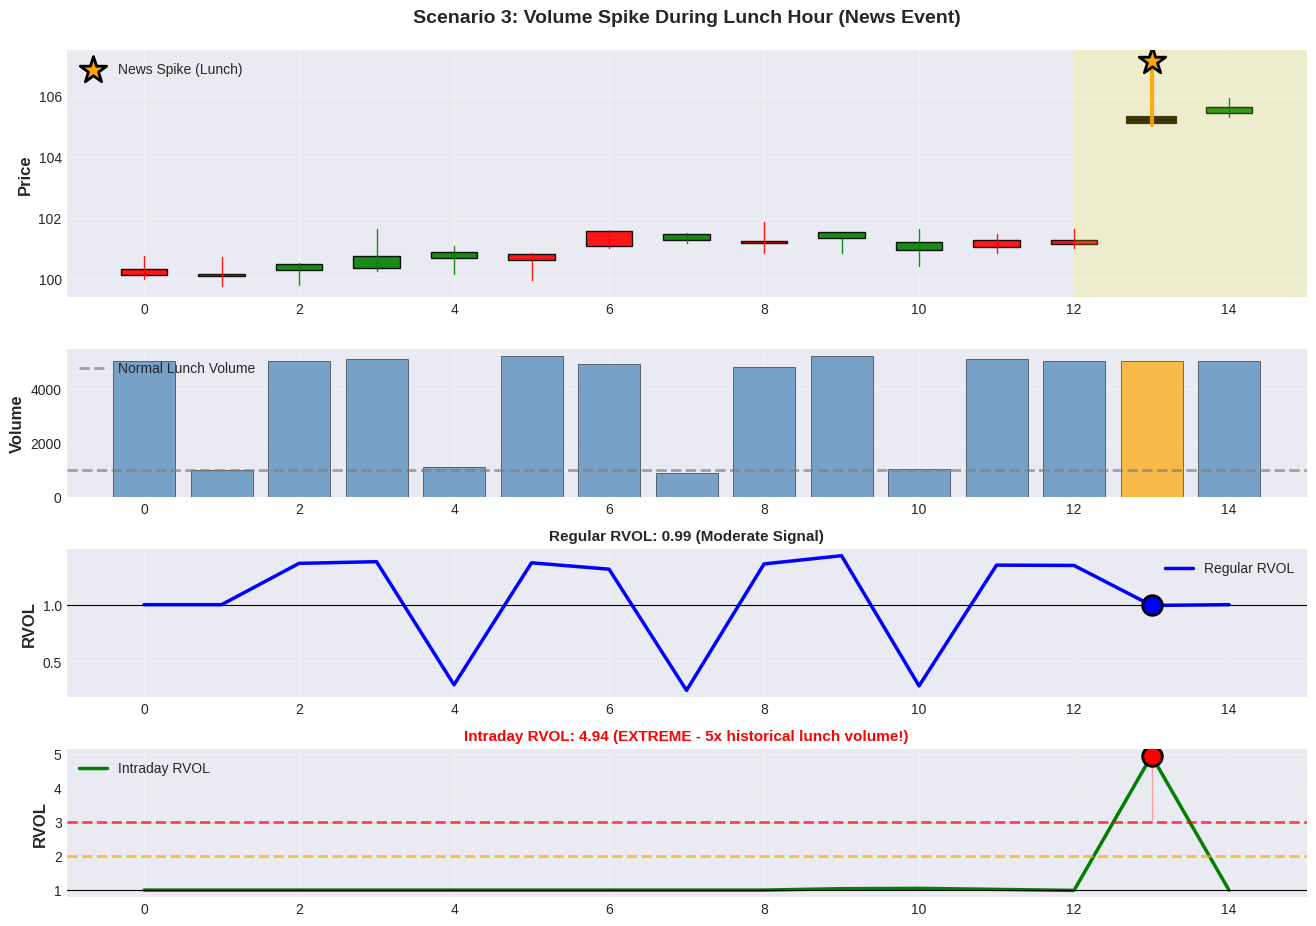

Lunch Hour Spike Analysis:
  Volume: 5000 (5x normal lunch volume of ~1000)
  Regular RVOL:  0.99
    → Compares to recent average (includes high open/close volumes)
  Intraday RVOL: 4.94
    → Compares to historical lunch average (~1000)

Intraday RVOL SCREAMS that this is extremely unusual for lunch hour!
This is exactly the kind of signal you want for news-driven trades.


In [4]:
# Day 5 has spike during LUNCH (normally low volume)
volumes3 = np.array([
    5000, 1000, 5000,  # Day 1
    5100, 1100, 5200,  # Day 2
    4900, 900, 4800,   # Day 3
    5200, 1050, 5100,  # Day 4
    5000, 5000, 5000,  # Day 5 - SPIKE at lunch (5x normal)
])

# Price: news spike during lunch
closes3 = closes1.copy()
closes3[13] = closes3[12] + 4  # Big move on news
closes3[14] = closes3[13] + 0.5

opens3 = closes3 + np.random.randn(15) * 0.2
highs3 = np.maximum(opens3, closes3) + np.abs(np.random.randn(15)) * 0.4
lows3 = np.minimum(opens3, closes3) - np.abs(np.random.randn(15)) * 0.4
highs3[13] = closes3[13] + 2  # Dramatic news candle

df3 = pd.DataFrame({
    'open': opens3, 'high': highs3, 'low': lows3, 'close': closes3, 'volume': volumes3
}, index=dates2)

result_regular3 = rvol(df3, window=3)
result_intraday3 = rvol_intraday(df3, min_samples=3)

# Plot
fig = plt.figure(figsize=(16, 11))
gs = GridSpec(4, 1, height_ratios=[2.5, 1.5, 1.5, 1.5], hspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax3 = fig.add_subplot(gs[2], sharex=ax1)
ax4 = fig.add_subplot(gs[3], sharex=ax1)

# Candlesticks
for i in range(len(df3)):
    if i == 13:  # News spike
        color = 'orange'
        lw = 3
    else:
        color = 'green' if df3['close'].iloc[i] >= df3['open'].iloc[i] else 'red'
        lw = 1
    ax1.plot([i, i], [df3['low'].iloc[i], df3['high'].iloc[i]], color=color, linewidth=lw, alpha=0.9)
    height = abs(df3['close'].iloc[i] - df3['open'].iloc[i])
    if height < 0.05: height = 0.2
    bottom = min(df3['open'].iloc[i], df3['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i-0.3, bottom), 0.6, height, facecolor=color, edgecolor='black', linewidth=lw, alpha=0.9))

ax1.scatter([13], [df3['high'].iloc[13]], s=400, marker='*', color='orange', edgecolor='black', linewidth=2, zorder=5, label='News Spike (Lunch)')
ax1.axvspan(12, 15, alpha=0.15, color='yellow')
ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Scenario 3: Volume Spike During Lunch Hour (News Event)', fontsize=14, fontweight='bold', pad=20)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-1, len(df3))

# Volume
colors_vol3 = ['orange' if i == 13 else 'steelblue' for i in range(len(df3))]
ax2.bar(range(len(df3)), df3['volume'], color=colors_vol3, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.axhline(1000, color='gray', linestyle='--', label='Normal Lunch Volume', linewidth=2, alpha=0.7)
ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(df3))

# Regular RVOL
rvol_reg3 = result_regular3['rvol'].values
ax3.plot(range(len(rvol_reg3)), rvol_reg3, 'blue', linewidth=2.5, label='Regular RVOL')
ax3.axhline(1, color='black', linestyle='-', linewidth=0.8)
ax3.scatter([13], [rvol_reg3[13]], s=200, color='blue', edgecolor='black', linewidth=2, zorder=5)
ax3.set_ylabel('RVOL', fontsize=12, fontweight='bold')
ax3.set_title(f'Regular RVOL: {rvol_reg3[13]:.2f} (Moderate Signal)', fontsize=11, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim(-1, len(df3))

# Intraday RVOL
rvol_intra3 = result_intraday3['rvol_intraday'].values
ax4.plot(range(len(rvol_intra3)), rvol_intra3, 'green', linewidth=2.5, label='Intraday RVOL')
ax4.axhline(1, color='black', linestyle='-', linewidth=0.8)
ax4.axhline(2, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax4.axhline(3, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax4.scatter([13], [rvol_intra3[13]], s=200, color='red', edgecolor='black', linewidth=2, zorder=5)
ax4.fill_between(range(len(df3)), 3, rvol_intra3, where=(rvol_intra3 > 3), alpha=0.3, color='red')
ax4.set_ylabel('RVOL', fontsize=12, fontweight='bold')
ax4.set_title(f'Intraday RVOL: {rvol_intra3[13]:.2f} (EXTREME - 5x historical lunch volume!)', fontsize=11, fontweight='bold', color='red')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(-1, len(df3))

plt.tight_layout()
plt.show()

print("Lunch Hour Spike Analysis:")
print(f"  Volume: 5000 (5x normal lunch volume of ~1000)")
print(f"  Regular RVOL:  {result_regular3['rvol'].iloc[13]:.2f}")
print(f"    → Compares to recent average (includes high open/close volumes)")
print(f"  Intraday RVOL: {result_intraday3['rvol_intraday'].iloc[13]:.2f}")
print(f"    → Compares to historical lunch average (~1000)")
print("\nIntraday RVOL SCREAMS that this is extremely unusual for lunch hour!")
print("This is exactly the kind of signal you want for news-driven trades.")

## Key Takeaways

### When to Use Each

**Regular RVOL (`rvol`):**
- Daily timeframe trading
- When intraday patterns don't matter
- Simpler to interpret and communicate
- Good for end-of-day scanners

**Intraday RVOL (`rvol_intraday`):**
- Intraday trading (scalping, day trading)
- Markets with strong time-of-day patterns
- News trading (detect unusual volume at any time)
- Avoid false signals from natural patterns

### RVOL Interpretation

**Both Types:**
- **RVOL > 3.0**: Extreme, major event
- **RVOL 2.0-3.0**: High, significant interest
- **RVOL 1.0-2.0**: Above average
- **RVOL 0.5-1.0**: Normal to below average
- **RVOL < 0.5**: Very low, avoid trading

### Parameters

**Regular RVOL:**
- `window`: 10-20 for intraday, 20-50 for daily

**Intraday RVOL:**
- `min_samples`: 3-5 (need history for each time slot)
- `lookback_days`: None (use all) or 30-60 (recent regime)

### Best Practices

1. **Use both!** Regular for magnitude, intraday for time-adjusted significance
2. **Combine with price action** - volume confirms moves, doesn't create them
3. **Adjust thresholds** - crypto needs higher thresholds than stocks
4. **Monitor key times** - open/lunch/close have different normal levels
5. **Lookback period** - recent data may better reflect current market regime

## Feature Showcase: Safety & Configuration

In [ ]:
# Configuration & Validation Showcase
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from indikator.rvol import rvol_intraday

# 1. Configuration with .Config()
print(f"--- Custom rvol_intraday Configuration ---")
# Create a fully configured version of the indicator
# This factory pattern validates parameters at creation time
custom_rvol_intraday = rvol_intraday.Config(min_samples=5).make()
print(f"Created: {custom_rvol_intraday}")

# 2. Validation Safety
print(f"
--- Input Validation Safety ---")
try:
    # Attempt to use invalid data (index requirements)
    invalid_data = pd.Series([100, 200]) # Missing DatetimeIndex
    print("Attempting calculation with invalid inputs...")
    rvol_intraday(invalid_data)
except Exception as e:
    # The @validated decorator automatically catches the issue
    print(f"✓ Validator caught error as expected:
  {e}")
